<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/Gillespie_Non_markovian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algoritmo Gillespie no-markoviano en redes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import newton
import networkx as nx

In [2]:
def Funciones_dado_metodo(u,method='',params=[],densities=[],survivals=[],aristas_en_riesgo=[],vertices_infecciosos=[]):
  if method=='general' or method=='aproximado':
    psi_infection,psi_recovery=densities
    psi_survival_infection,psi_survival_recovery=survivals
    def f_to_solve_general(x):
      S_1=np.sum([np.log(psi_survival_infection(x+r)) for r in aristas_en_riesgo['tiempo']])
      S_2=np.sum([np.log(psi_survival_recovery(x+r)) for r in vertices_infecciosos['tiempo']])
      S_3=np.sum([np.log(psi_survival_infection(r)) for r in aristas_en_riesgo['tiempo']])
      S_4=np.sum([np.log(psi_survival_recovery(r)) for r in vertices_infecciosos['tiempo']])
      return (S_1+S_2-S_3-S_4-np.log(u))
    def f_to_solve_general_prime(x):
      S_1=np.sum([(psi_infection(x+r)/psi_survival_infection(x+r)) for r in aristas_en_riesgo['tiempo']])
      S_2=np.sum([(psi_recovery(x+r)/psi_survival_recovery(x+r)) for r in vertices_infecciosos['tiempo']])
      return (-S_1-S_2)
    return 0,0,0,0,f_to_solve_general,f_to_solve_general_prime
  if method=='Weibull':
    a_I,a_R,lammbda_I,lammbda_R=params
    def f_to_solve(x):
      S_1=np.sum([(x+r)**(a_I) for r in aristas_en_riesgo['tiempo']])
      S_2=np.sum([(x+r)**(a_R) for r in vertices_infecciosos['tiempo']])
      S_3=np.sum([r**a_I for r in aristas_en_riesgo['tiempo']])
      S_4=np.sum([r**a_R for r in vertices_infecciosos['tiempo']])
      return ((lammbda_I**(a_I))*(S_1-S_3)+(lammbda_R**(a_R))*(S_2-S_4)+np.log(u))
    def f_to_solve_prime(x):
      S_1=a_I*np.sum([(x+r)**(a_I-1) for r in aristas_en_riesgo['tiempo']])
      S_2=a_R*np.sum([(x+r)**(a_R-1) for r in vertices_infecciosos['tiempo']])
      return (a_I*(lammbda_I**(a_I))*S_1+a_R*(lammbda_R**(a_R))*S_2)
    return  a_I,a_R,lammbda_I,lammbda_R,f_to_solve,f_to_solve_prime
def Gillespie_Direct_Method_Non_markovian_network(N,X_I_indexes,method='',params=[],densities=[],survivals=[],G_network_initial=nx.Graph(),T=np.inf,tuto=False):
  #Recibe: method:
    #'general': Dando las densidades y supervivencias
    #'aproximado': Dando las densidades y supervivencias
    #'Weibull': Dando un vector de parámetros con $a_I,a_R,lammbda_I,lammbda_R"
  #Recibe: G_newtwork_initial la gráfica generada con Networkx
  #Recibe: X_I_indexes, un vector de indices de los nodos incicialmente infecciosos (al tiempo t=0)

  #--------------------------------------
  #Paso 0
  t=0
  X_I=len(X_I_indexes)
  X_S=N-X_I
  X_R=0
  Historia=[[0,X_S,X_I]]
  #Definir aristas_en_riesgo:
  aristas_en_riesgo={'arista':[],'tiempo':[]}
  vertices_infecciosos={'vertice':[],'tiempo':[]}
  #Llenar estos arreglos.
  #N es el número de individuos.
  for j in X_I_indexes:
    vertices_infecciosos['vertice'].append(j)
    vertices_infecciosos['tiempo'].append(0)
    for i in range(N):
      if G_network_initial.has_edge(i,j) and i not in X_I_indexes:
        aristas_en_riesgo['arista'].append((min(i,j),max(i,j)))#Los agregamos en un orden específico.
        aristas_en_riesgo['tiempo'].append(0)
  #--------------------------------------
  if(tuto):
    print("Inicia:")
    print("Condiciones iniciales: N=",N,'X_I=',len(X_I_indexes))
    print("aristas_en_riesgo:",aristas_en_riesgo['arista'])
    print("vertices_infecciosos:",vertices_infecciosos['vertice'])
    print("Asi se ve la grafica:n")
    nx.draw(G=G_network_initial,pos=pos,node_color=['green' if G_network_initial.nodes[i]['Estado:']=='Susceptible' else 'red' if G_network_initial.nodes[i]['Estado:']=='Infeccioso' else 'gray' for i in G.nodes()],with_labels=True)
    plt.show()
  #Paso 1
  while(X_I>0 and t<T):
    u=np.random.uniform()
    #Definir la funcion $\Phi$.
    #Depende del metodo y los valores introducidos.
    a_I,a_R,lammbda_I,lammbda_R,f_to_solve,f_to_solve_prime=Funciones_dado_metodo(u=u,method=method,params=params,densities=densities,survivals=survivals,aristas_en_riesgo=aristas_en_riesgo,vertices_infecciosos=vertices_infecciosos)
    #--------------------------------------
    #Paso 2
    tau=0.001
    if method=='aproximado':
      if(len(aristas_en_riesgo['tiempo'])+len(vertices_infecciosos['tiempo'])>=20 ):
        sum=0
        for r in aristas_en_riesgo['tiempo']:
          sum+=psi_infection(r)/psi_survival_infection(r)
        for r in vertices_infecciosos['tiempo']:
          sum+=psi_recovery(r)/psi_survival_recovery(r)
        if(sum>0):
          tau=-np.log(u)/(sum)
      else:
        tau=newton(func=f_to_solve,x0=tau/2,fprime=f_to_solve_prime)
    else:
      tau=newton(func=f_to_solve,x0=tau/2,fprime=f_to_solve_prime)
    #--------------------------------------
    #Paso 3-4
    #Definir las probabilidades de elección de cada canal
    if method=='Weibull':
      pi_s_teoricas=[]
      sum=0
      for j in range(len(aristas_en_riesgo['tiempo'])):
        pi_s_teoricas.append(lammbda_I*a_I*(lammbda_I*(tau+aristas_en_riesgo['tiempo'][j]))**(a_I-1))
      for j in range(len(vertices_infecciosos['tiempo'])):
        pi_s_teoricas.append(lammbda_R*a_R*(lammbda_R*(tau+vertices_infecciosos['tiempo'][j]))**(a_R-1))
      pi_s=pi_s_teoricas/np.sum(pi_s_teoricas)
    else:
      pi_s=[]
      sum=0
      for i in range(len(aristas_en_riesgo['tiempo'])):
        pi_s.append(psi_infection(aristas_en_riesgo['tiempo'][i]+tau)/psi_survival_infection(aristas_en_riesgo['tiempo'][i]+tau))
        sum+=pi_s[-1]
      for i in range(len(vertices_infecciosos['tiempo'])):
        pi_s.append(psi_recovery(vertices_infecciosos['tiempo'][i]+tau)/psi_survival_recovery(vertices_infecciosos['tiempo'][i]+tau))
        sum+=pi_s[-1]
      pi_s=pi_s/sum
    #--------------------------------------
    #Paso 5
    #Decidir el canal de reacción.
    k=np.random.choice(len(pi_s),p=pi_s)
    #--------------------------------------
    if(tuto):
      print("\nOcurre una iteracion:")
      print("Se genera un tiempo ", tau)
      print("De un vector de probabilidades: ",pi_s)
      print("Se selecciona el canal de reaccion con indice ",k)
    #Paso 6
    #Actualizamos los tiempos desde la última reacción de todos los canales.
    #I.e. A todas las aristas en riesgo y todos los vértices infecciosos, se les actualiza $t_j+=t_j+tau$
    #Incluso para la reacción que Sí ocurrió, pues más adelanta la eliminamos.
    aristas_en_riesgo['tiempo']=[tau+x for x in aristas_en_riesgo['tiempo']]
    vertices_infecciosos['tiempo']=[tau+x for x in vertices_infecciosos['tiempo']]
    if k<len(aristas_en_riesgo['tiempo']):
      #Ocurre una infección.
      reaccion='infeccion'
      X_I+=1
      X_S-=1
      arista_elegida=aristas_en_riesgo['arista'][k]#k<len(aristas)
      involucrado_1,involucrado_2=arista_elegida[0],arista_elegida[1]
      #Identificar al nuevo infectado-------------
      if(G_network_initial.nodes[involucrado_1]['Estado:']=='Susceptible'):
      #involucrado_1 es el nuevo infeccioso
        nuevo_infectado=involucrado_1
      else:
        if(G_network_initial.nodes[involucrado_1]['Estado:']=='Infeccioso'):
          nuevo_infectado=involucrado_2
        else:
          print("Algo malo esta ocurriendo")
      G_network_initial.nodes[nuevo_infectado]['Estado:']='Infeccioso'#Actualizacion en el grafo.
      #-------------------------
      #Agregarlo a la lista vertices_infecciosos con tiempo 0----
      vertices_infecciosos['vertice'].append(nuevo_infectado)
      vertices_infecciosos['tiempo'].append(0)
      #-------------------------
      #Agrega a la lista aristas_en_riesgo a aquellas nuevas aristas que podrían provocar una infección, con tiempo 0.
      for nei in G_network_initial.neighbors(nuevo_infectado):
        if(G_network_initial.nodes[nei]['Estado:']=='Susceptible'):
          aristas_en_riesgo['arista'].append((min(nei,nuevo_infectado),max(nei,nuevo_infectado)))
          aristas_en_riesgo['tiempo'].append(0)
        else:
          if(G_network_initial.nodes[nei]['Estado:']=='Infeccioso'):#Arista Infeccioso-Infeccioso, la quitamos.
            index=aristas_en_riesgo['arista'].index((min(nuevo_infectado,nei),max(nuevo_infectado,nei)))
            aristas_en_riesgo['arista'].pop(index)
            aristas_en_riesgo['tiempo'].pop(index)
      nuevo_involucrado=nuevo_infectado
      #-------------------------
    else:
      #Ocurre una recuperación.
      reaccion='recuperacion'
      X_I-=1
      X_R+=1
      indice_respecto_vertices=k-len(aristas_en_riesgo['tiempo'])#k>=len(aristas). I.e. Es vértice
      nuevo_recuperado=vertices_infecciosos['vertice'][indice_respecto_vertices]
      #Actualiza el estado a Recuperado.
      G_network_initial.nodes[nuevo_recuperado]['Estado:']='Recuperado'#Actualizacion en el grafo.
      #-----------------------------
      #Elimina de la lista vertices_infecciosos al nuevo recuperado.
      vertices_infecciosos['vertice'].pop(indice_respecto_vertices)
      vertices_infecciosos['tiempo'].pop(indice_respecto_vertices)
      #-----------------------------
      #Elimina de la lista aristas_en_riesgo a aquellas aristas que involucran al nuevo recuperado.
      aristas_en_riesgo_copia=aristas_en_riesgo['arista'].copy()
      count=-1
      for l in range(len(aristas_en_riesgo_copia)):
        edge=aristas_en_riesgo_copia[l]
        if(edge[0]==nuevo_recuperado or edge[1]==nuevo_recuperado):
          count+=1
          aristas_en_riesgo['arista'].pop(l-count)
          aristas_en_riesgo['tiempo'].pop(l-count)
      nuevo_involucrado=nuevo_recuperado
    t+=tau #Actualiza el tiempo $t=t+\tau$.
    Historia.append([t,X_S,X_I])#Focus
    if(tuto):
      print("Ocurre la reaccion ",reaccion, ' que involucra al nodo ',nuevo_involucrado)
      print("Asi se ve la grafica despues de actualizar:n")
      nx.draw(G=G_network_initial,pos=pos,node_color=['green' if G_network_initial.nodes[i]['Estado:']=='Susceptible' else 'red' if G_network_initial.nodes[i]['Estado:']=='Infeccioso' else 'gray' for i in G.nodes()],with_labels=True)
      plt.show()
  #Fin del While()
  return pd.DataFrame(Historia,columns=['time','S(t)','I(t)'])

## Tutorial
Tiene una variable $tuto$ que imprime las variables de interés en cada iteración.

Inicia:
Condiciones iniciales: N= 10 X_I= 2
aristas_en_riesgo: [(1, 6), (2, 6), (4, 6), (6, 7), (0, 9), (3, 9), (7, 9)]
vertices_infecciosos: [6, 9]
Asi se ve la grafica:n


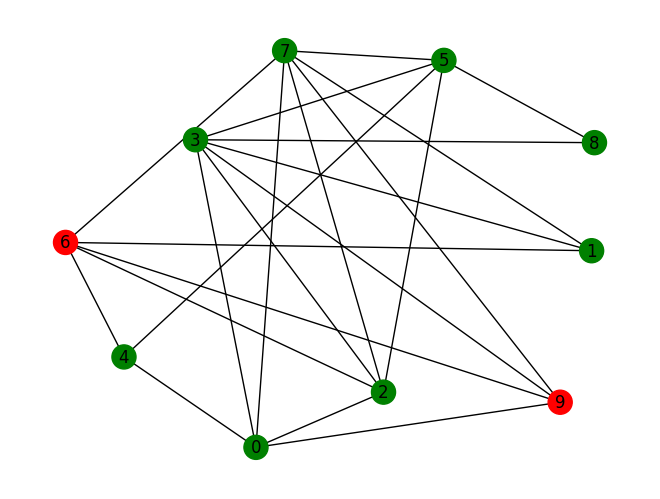


Ocurre una iteracion:
Se genera un tiempo  0.12876681050805674
De un vector de probabilidades:  [0.09932062 0.09932062 0.09932062 0.09932062 0.09932062 0.09932062
 0.09932062 0.15237783 0.15237783]
Se selecciona el canal de reaccion con indice  8
Ocurre la reaccion  recuperacion  que involucra al nodo  9
Asi se ve la grafica despues de actualizar:n


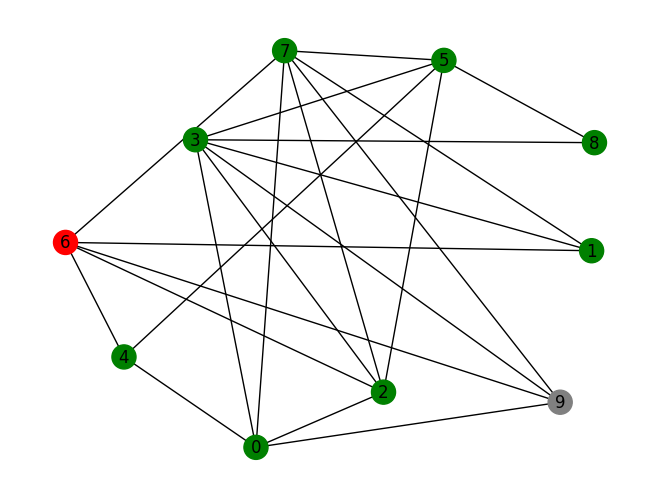


Ocurre una iteracion:
Se genera un tiempo  0.03475966852247383
De un vector de probabilidades:  [0.18069455 0.18069455 0.18069455 0.18069455 0.27722181]
Se selecciona el canal de reaccion con indice  4
Ocurre la reaccion  recuperacion  que involucra al nodo  6
Asi se ve la grafica despues de actualizar:n


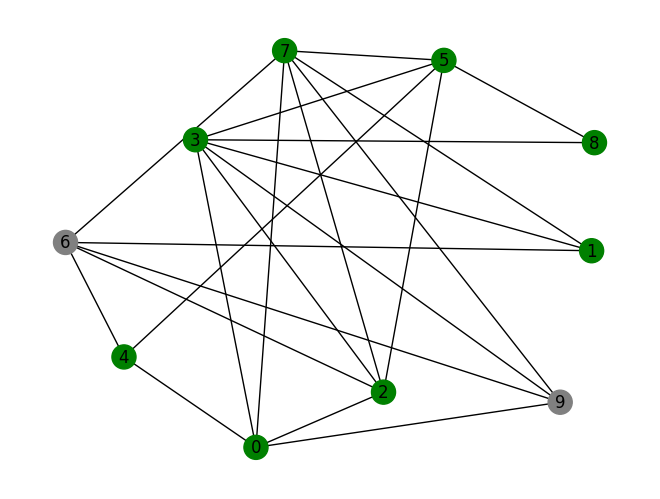

In [ ]:
N=10
X_I_indexes=np.random.choice(N,size=2,replace=False)
beta=7
gamma=1
G=nx.fast_gnp_random_graph(n=N,p=0.5)
pos=nx.spring_layout(G,seed=2,k=3)
for k in range(N):
  if k in X_I_indexes:
    G.nodes[k]['Estado:']='Infeccioso'
  else:
    G.nodes[k]['Estado:']='Susceptible'
a_I,a_R=1.2,1.2
lammbda_I=beta/N
lammbda_R=gamma
def psi_survival_infection(x):
    return np.exp(-(lammbda_I*x)**(a_I))
def psi_survival_recovery(x):
    return np.exp(-(lammbda_R*x)**(a_R))
def psi_infection(x):
    return (lammbda_I*a_I)*(lammbda_I*x)**(a_I-1)*np.exp(-(lammbda_I*x)**(a_I))
def psi_recovery(x):
    return (lammbda_R*a_R)*(lammbda_R*x)**(a_R-1)*np.exp(-(lammbda_R*x)**(a_R))
H=Gillespie_Direct_Method_Non_markovian_network(N=N,X_I_indexes=X_I_indexes,method='aproximado',params=[1.2,1.2,beta/N,gamma],densities=[psi_infection,psi_recovery],survivals=[psi_survival_infection,psi_survival_recovery],G_network_initial=G,T=np.inf,tuto=True)

## Ejemplo: Gráfica completa con distribuciones exponenciales.

In [3]:
def Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes):
    Lambda=np.sum(Lambdas)
    tau=np.random.exponential(scale=1/Lambda)
    u_2=np.random.uniform(0,1)
    if(u_2<(Lambda-Lambdas[-1])/Lambda):#Infeccion
        u_3=np.random.uniform(0,1)
        D=0
        k=0
        while(u_3>D):
            D+=Lambdas[k]/(Lambda-Lambdas[-1])
            k+=1
        new_reaction_index=np.random.choice(range(len(dict_num_contacts[str(k-1)])))
        new_reaction=dict_num_contacts[str(k-1)][new_reaction_index]
    else:#Recuperación
        k=0
        new_reaction_index=np.random.choice(range(len(X_I_indexes)))
        new_reaction=X_I_indexes[new_reaction_index]
    return tau,new_reaction,k-1,new_reaction_index
def Gillespie_Direct_Method_Network(beta,gamma,N,X_I_indexes,G_network_initial=nx.Graph(),T=np.inf):
    flag=True
    #Paso 1.
    t=0 #Inicializar $t=0$.
    #Calcular $k_i$ el número de contactos infecciosos del individuo $i$.--------------------
    X_I=len(X_I_indexes)
    X_S=N-X_I
    Historia=[[0,X_S,X_I]]
    dict_num_contacts = {}
    for n in range(X_I+1):
        dict_num_contacts[str(n)]=[]
    num_cont_inf_por_indice=np.zeros(N)
    for i in range(N):
        if(i not in X_I_indexes): #No es infeccioso.
            count_for_i=0
            for j in X_I_indexes:
                if (G_network_initial.has_edge(i,j)):#Es un contacto Susceptible-infeccioso.
                    num_cont_inf_por_indice[i]+=1#Ya que voy a hacer los ciclos, mejor la guardo igual.
                    count_for_i+=1
            dict_num_contacts[str(count_for_i)].append(i)
    #-------------------------------------------
    while(flag):
        #Generar las Lambdas------------------
        Lambda=0
        Lambdas=[]
        for k in range(len(list(dict_num_contacts.keys()))):
            Lambdas.append((beta/N)*len(dict_num_contacts[str(k)])*k)#
            Lambda+=Lambdas[-1]
        Lambdas.append(gamma*X_I)
        Lambda+=Lambdas[-1]
        #-------------------------------------------
        #Paso Monte-Carlo---------------------------
        tau,new_reaction,k_choice,new_reaction_index=Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes)
        #-------------------------------------------
        #Actualización del sistema.
        if(G_network_initial.nodes[new_reaction]['Estado:']=='Susceptible'):#Se trata de una infección
            num_cont_inf_por_indice[new_reaction]=0
            G_network_initial.nodes[new_reaction]['Estado:']='Infeccioso'#Actualizar su estado
            X_I_indexes.append(new_reaction)
            i=new_reaction
            dict_num_contacts[str(k_choice)].pop(new_reaction_index)#Saca al nuevo infeccioso del conjunto con exactamente k_choice contactos infecciosos.
            #Para cada nodo $j$ conectado a $i$, actualizamos su número de contactos infecciosos como $k_j=k_j+1.$--------------------
            num_max_cont=int(list(dict_num_contacts.keys())[-1])
            for vecino in G_network_initial.neighbors(i):#Para cada vecino del nuevo infectado, le aumentamos el numero de contactos en 1. (lo agregamos a la siguiente categoria y lo sacamos de la anterior)
                if (G_network_initial.nodes[vecino]['Estado:']=='Susceptible'):

                    num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                    if(num_cont_del_vecino+1>num_max_cont):#Si mas de uno crea una categoria, hay error.
                        num_max_cont+=1
                        dict_num_contacts[str(int(num_cont_del_vecino+1))]=[vecino]
                    else:
                        dict_num_contacts[str(int(num_cont_del_vecino+1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]+=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        else:
            G_network_initial.nodes[new_reaction]['Estado:']='Recuperado'
            num_cont_inf_por_indice[new_reaction]=0#Ya no es relevante
            X_I_indexes.pop(new_reaction_index)
            i=new_reaction
            #Para cada nodo $j$ conectado a $i^* $, actualizamos su número de contactos infecciosos como $k_j=k_j-1.$
            for vecino in G_network_initial.neighbors(i):#Podria ser que ya no tuviera ningun contacto
                num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                if(num_cont_del_vecino!=0):# Es recuperado.
                    dict_num_contacts[str(int(num_cont_del_vecino-1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]-=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        t+=tau #Actualiza el tiempo $t=t+\tau$.
        X_I=len(X_I_indexes)
        X_S=N-X_I
        Historia.append([t,X_S,X_I])#Focus
        if(X_I==0):
            flag=False
    return pd.DataFrame(Historia,columns=['time','S(t)','I(t)'])

## Comprobación de algoritmo no-markoviano.
### Recuperamos el funcionamiento del caso markoviano cuando consideramos distribuciones exponenciales.

--- 0.1658339500427246 Segundos para crear la gráfica ---
Empieza


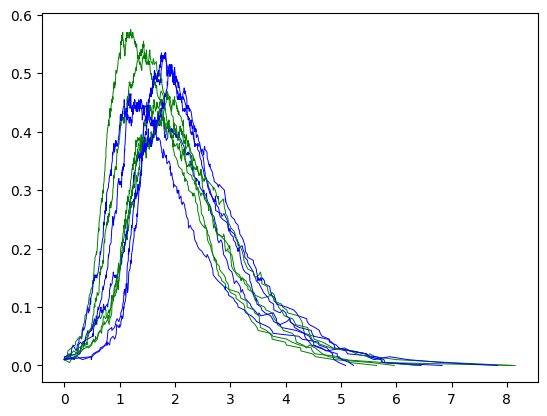

In [ ]:
import time
start_time = time.time()
N=2*10**2
G=nx.complete_graph(N)
pos=nx.spring_layout(G,seed=2,k=3)
print("--- %s Segundos para crear la gráfica ---" % (time.time() - start_time))
graph_time = time.time()
p_i_0=0.01
I_0=int(p_i_0*N)
S_0=N-I_0
R_0=0
X_I_indexes=np.random.choice(N,size=I_0,replace=False).tolist()
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
print("Empieza")
a_I=1.0
a_R=1.0
lammbda_I=5/N
lammbda_R=1.0
def psi_survival_infection(x):
    return np.exp(-(lammbda_I*x)**(a_I))
def psi_survival_recovery(x):
    return np.exp(-(lammbda_R*x)**(a_R))
def psi_infection(x):
    return (lammbda_I*a_I)*(lammbda_I*x)**(a_I-1)*np.exp(-(lammbda_I*x)**(a_I))
def psi_recovery(x):
    return (lammbda_R*a_R)*(lammbda_R*x)**(a_R-1)*np.exp(-(lammbda_R*x)**(a_R))
for k in range(5):
    H=[]
    G_copy=G.copy()
    X_I_indexes_copy=X_I_indexes.copy()
    iter_time = time.time()
    H=Gillespie_Direct_Method_Non_markovian_network(N=N,X_I_indexes=X_I_indexes_copy,method='general',params=[],densities=[psi_infection,psi_recovery],survivals=[psi_survival_infection,psi_survival_recovery],G_network_initial=G_copy,T=np.inf)
    if(k==0):
      plt.plot(H['time'],H['I(t)']/N, 'green',linewidth=0.7,label='no-markoviano')
    else:
      plt.plot(H['time'],H['I(t)']/N, 'green',linewidth=0.7)
    G_copy=G.copy()
    X_I_indexes_copy=X_I_indexes.copy()
    iter_time = time.time()
    H=Gillespie_Direct_Method_Network(beta=5,gamma=1.0,N=N,X_I_indexes=X_I_indexes_copy,G_network_initial=G_copy,T=np.inf)
    if(k==0):
      plt.plot(H['time'],H['I(t)']/N, 'blue',linewidth=0.7,label='markoviano')
    else:
      plt.plot(H['time'],H['I(t)']/N, 'blue',linewidth=0.7)
plt.show()

## Comparación en modelo de configuración
### Markoviano
### Método general
### Aproximación usando Taylor
### Weibull

--- 10.725844144821167 Segundos para crear la gráfica ---
Empieza


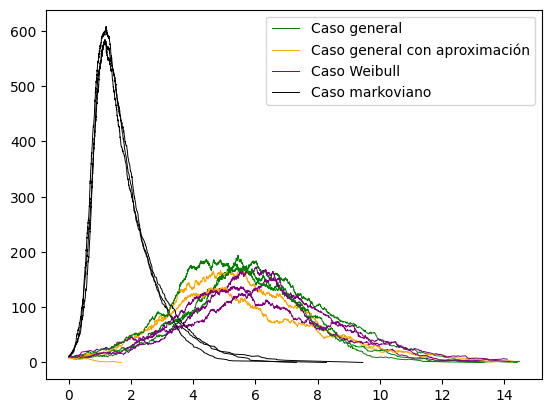

In [4]:
import time
start_time = time.time()
np.random.seed(0)
N=10**3
n=int(N*0.1)
I_0=int(0.01*N)
ksum=1
while(ksum%2!=0):#Que defina una grafica.
        k_dist=np.random.poisson(n,size=N)
        ksum=sum(k_dist)
G=nx.configuration_model(k_dist)
G = nx.Graph(G)#Remover multi-aristas
G.remove_edges_from(nx.selfloop_edges(G))#Remover bucles
pos=nx.spring_layout(G,seed=2,k=3)
print("--- %s Segundos para crear la gráfica ---" % (time.time() - start_time))
X_I_indexes=np.random.choice(N,size=I_0,replace=False).tolist()
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
print("Empieza")
a_I=1.5
a_R=1.2
import math
beta=75
gamma=1
lammbda_I=((beta/N)*math.gamma(1+1/a_I))
lammbda_R=(gamma*math.gamma(1+1/a_R))
def psi_survival_infection(x):
    return np.exp(-(lammbda_I*x)**(a_I))
def psi_survival_recovery(x):
    return np.exp(-(lammbda_R*x)**(a_R))
def psi_infection(x):
    return (lammbda_I*a_I)*(lammbda_I*x)**(a_I-1)*np.exp(-(lammbda_I*x)**(a_I))
def psi_recovery(x):
    return (lammbda_R*a_R)*(lammbda_R*x)**(a_R-1)*np.exp(-(lammbda_R*x)**(a_R))
times_general=[]
times_general_approx=[]
times_weibull=[]
times_markovian=[]
picos={"gen":[],"genApprox":[],"weib":[],"mark":[]}
for k in range(3):
    #------------------------------------ General
    iter_time = time.time()
    H=[]
    while(len(H)<10):
      G_copy=G.copy()
      X_I_indexes_copy=X_I_indexes.copy()
      H=Gillespie_Direct_Method_Non_markovian_network(N=N,X_I_indexes=X_I_indexes_copy,method='general',params=[],densities=[psi_infection,psi_recovery],survivals=[psi_survival_infection,psi_survival_recovery],G_network_initial=G_copy,T=14)
    if(k==0):
        plt.plot(H['time'],H['I(t)'], 'green',linewidth=0.7,label='Caso general ')
    else:
        plt.plot(H['time'],H['I(t)'], 'green',linewidth=0.7)
    i=np.argmax(H['I(t)'])
    picos['gen'].append([H['time'][i],H['I(t)'][i]])
    times_general.append((time.time() - iter_time))
    #------------------------------------
    #------------------------------------ General aproximado
    iter_time = time.time()
    H=[]
    while(len(H)<10):
      G_copy=G.copy()
      X_I_indexes_copy=X_I_indexes.copy()
      H=Gillespie_Direct_Method_Non_markovian_network(N=N,X_I_indexes=X_I_indexes_copy,method='aproximado',params=[],densities=[psi_infection,psi_recovery],survivals=[psi_survival_infection,psi_survival_recovery],G_network_initial=G_copy,T=14)
    if(k==0):
        plt.plot(H['time'],H['I(t)'], 'orange',linewidth=0.7,label='Caso general con aproximación')
    else:
        plt.plot(H['time'],H['I(t)'], 'orange',linewidth=0.7)
    i=np.argmax(H['I(t)'])
    picos['genApprox'].append([H['time'][i],H['I(t)'][i]])
    times_general_approx.append((time.time() - iter_time))
    #------------------------------------
    #------------------------------------ Weibull
    iter_time = time.time()
    H=[]
    while(len(H)<10):
      G_copy=G.copy()
      X_I_indexes_copy=X_I_indexes.copy()
      H=Gillespie_Direct_Method_Non_markovian_network(N=N,X_I_indexes=X_I_indexes_copy,method='Weibull',params=[a_I,a_R,lammbda_I,lammbda_R],G_network_initial=G_copy,T=14)
    if(k==0):
        plt.plot(H['time'],H['I(t)'], 'purple',linewidth=0.7,label='Caso Weibull')
    else:
        plt.plot(H['time'],H['I(t)'], 'purple',linewidth=0.7)
    i=np.argmax(H['I(t)'])
    picos['weib'].append([H['time'][i],H['I(t)'][i]])
    times_weibull.append((time.time() - iter_time))
    #------------------------------------
    #------------------------------------ Markoviano
    iter_time = time.time()
    H=[]
    while(len(H)<10):
      G_copy=G.copy()
      X_I_indexes_copy=X_I_indexes.copy()
      H=Gillespie_Direct_Method_Network(beta,gamma,N,X_I_indexes=X_I_indexes_copy,G_network_initial=G_copy,T=14)
    if(k==0):
        plt.plot(H['time'],H['I(t)'], 'black',linewidth=0.7,label='Caso markoviano')
    else:
        plt.plot(H['time'],H['I(t)'], 'black',linewidth=0.7)
    i=np.argmax(H['I(t)'])
    picos['mark'].append([H['time'][i],H['I(t)'][i]])
    times_markovian.append((time.time() - iter_time))
    #------------------------------------
plt.legend()
plt.savefig('comparacion.png',dpi=300)
plt.show()
print("--- %s Segundos en promedio para ejecutar 1 iteracion del general ---" %np.mean(times_general))
print("--- %s Segundos en promedio para ejecutar 1 iteracion del general usando aproximacion---" %np.mean(times_general_approx))
print("--- %s Segundos en promedio para ejecutar 1 iteracion del caso Weibull ---" % np.mean(times_weibull))
print("--- %s Segundos en promedio para ejecutar 1 iteracion del caso markoviano ---" % np.mean(times_markovian))

In [5]:
print('----------------------------------------------------------\n')
print('gen:     ',np.mean(picos['gen'],axis=0)[0],'    ',np.mean(picos['gen'],axis=0)[1], '      ',np.round(np.mean(times_general)))
print('----------------------------------------------------------\n')
print('genApprox: ',np.mean(picos['genApprox'],axis=0)[0],'    ',np.mean(picos['genApprox'],axis=0)[1], '      ',np.round(np.mean(times_general_approx)))
print('----------------------------------------------------------\n')
print('weib:     ',np.mean(picos['weib'],axis=0)[0],'    ',np.mean(picos['weib'],axis=0)[1], '      ',np.round(np.mean(times_weibull)))
print('----------------------------------------------------------\n')
print('mark:     ',np.mean(picos['mark'],axis=0)[0],'    ',np.mean(picos['mark'],axis=0)[1], '      ',np.round(np.mean(times_markovian)))

--- 382.33511233329773 Segundos en promedio para ejecutar 1 iteracion del general ---
--- 56.51180720329285 Segundos en promedio para ejecutar 1 iteracion del general usando aproximacion---
--- 87.94742600123088 Segundos en promedio para ejecutar 1 iteracion del caso Weibull ---
--- 0.7443971633911133 Segundos en promedio para ejecutar 1 iteracion del caso markoviano ---
----------------------------------------------------------

gen:      5.265208336550059      188.33333333333334        382.0
----------------------------------------------------------

genApprox:  3.545053660410115      105.33333333333333        57.0
----------------------------------------------------------

weib:      5.936927732087683      155.0        88.0
----------------------------------------------------------

mark:      1.179814177937108      592.0        1.0
